# TensorFlow 2.0 alpha - Load Images with tf.data

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import pathlib

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Download and Inspect Dataset
#### Retrieve Images
* Before training, use images to teach the network about classes it needs to recognize
* Use an archive of creative-commons licensed flower photos

In [3]:
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                        fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

228818944/228813984 [==============================] - 79s 0us/step
/Users/MPHA/.keras/datasets/flower_photos


In [4]:
for item in data_root.iterdir():
    print(item)

/Users/MPHA/.keras/datasets/flower_photos/daisy
/Users/MPHA/.keras/datasets/flower_photos/dandelion
/Users/MPHA/.keras/datasets/flower_photos/LICENSE.txt
/Users/MPHA/.keras/datasets/flower_photos/roses
/Users/MPHA/.keras/datasets/flower_photos/sunflowers
/Users/MPHA/.keras/datasets/flower_photos/tulips


In [5]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [6]:
all_image_paths[:10]

['/Users/MPHA/.keras/datasets/flower_photos/sunflowers/14814264272_4b39a102f9_n.jpg',
 '/Users/MPHA/.keras/datasets/flower_photos/dandelion/3580437733_9ef51f2981_n.jpg',
 '/Users/MPHA/.keras/datasets/flower_photos/roses/4918137796_21f0922b0c_n.jpg',
 '/Users/MPHA/.keras/datasets/flower_photos/dandelion/5110102140_787d325757_n.jpg',
 '/Users/MPHA/.keras/datasets/flower_photos/tulips/6994351792_343e18cbf6_n.jpg',
 '/Users/MPHA/.keras/datasets/flower_photos/dandelion/2569516382_9fd7097b9b.jpg',
 '/Users/MPHA/.keras/datasets/flower_photos/sunflowers/20777358950_c63ea569a1.jpg',
 '/Users/MPHA/.keras/datasets/flower_photos/sunflowers/6053739964_a1d9ab3ed1_n.jpg',
 '/Users/MPHA/.keras/datasets/flower_photos/daisy/8489463746_a9839bf7e4.jpg',
 '/Users/MPHA/.keras/datasets/flower_photos/dandelion/8079778274_f2a400f749_n.jpg']

## Inspect the Images

In [7]:
import os
attributions = (data_root/'LICENSE.txt').open(encoding='utf-8').readlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)

In [8]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return 'Image (CC BY 2.0) ' + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])

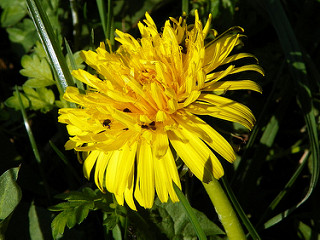

Image (CC BY 2.0)  by Peter O'Connor aka anemoneprojectors



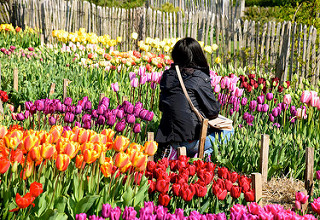

Image (CC BY 2.0)  by Maria  Eklind



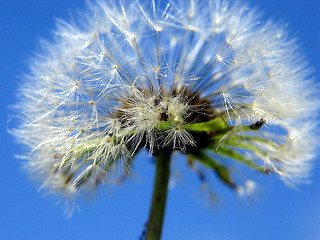

Image (CC BY 2.0)  by frankieleon



In [9]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    
    print(caption_image(image_path))
    print()

## Determine the Label for each Image
#### List available labels

In [10]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

#### Assign an index to each label

In [11]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

#### Create a list of every file, and its label index

In [12]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                   for path in all_image_paths]

print('First 10 labels indices: ', all_image_labels[:10])

First 10 labels indices:  [3, 1, 2, 1, 4, 1, 3, 3, 0, 1]


## Load and Format Images

In [13]:
img_path = all_image_paths[0]
img_path

'/Users/MPHA/.keras/datasets/flower_photos/sunflowers/14814264272_4b39a102f9_n.jpg'

In [14]:
# here is the Raw Data

img_raw = tf.io.read_file(img_path)

print(repr(img_raw)[:100]+'...')

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x...


#### Decode this to an Image Tensor

In [15]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(213, 320, 3)
<dtype: 'uint8'>


#### Resize it for the Model

In [16]:
img_final = tf.image.resize(img_tensor, [192, 192])
img_final = img_final / 255.0

print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
1.0


#### Turn these into Functions for later use

In [17]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0
    
    return image

In [18]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    
    return preprocess_image(image)

In [19]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path))
plt.title(label_names[label].title())
print()

## Build a tf.data.Dataset - Dataset of Images
#### Easiest way to build one is using from_tensor_slices - slices array of strings, into dataset of strings

In [20]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

#### Shapes and Types - describe the content of each dataset item - a set of scalar binary-strings

In [21]:
print(path_ds)

<TensorSliceDataset shapes: (), types: tf.string>


#### The dataset loads and formats images - by mapping preprocess_image, over the dataset of paths

In [22]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

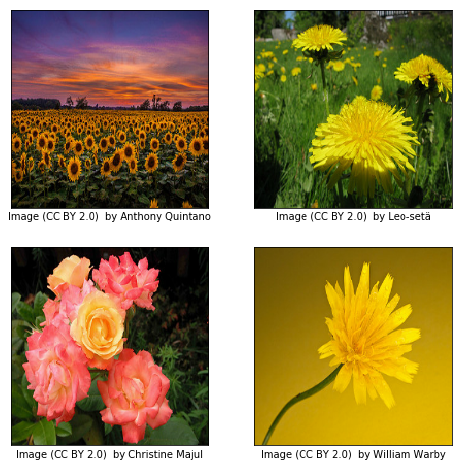

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
    plt.subplot(2, 2, n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(caption_image(all_image_paths[n]))

## Dataset of (image, label) pairs
#### Also use from_tensor_slices - build a dataset of labels

In [24]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [25]:
for label in label_ds.take(10):
    print(label_names[label.numpy()])

sunflowers
dandelion
roses
dandelion
tulips
dandelion
sunflowers
sunflowers
daisy
dandelion


#### Datasets are in the same order - can be Zipped Together for a dataset of (image, label) pairs

In [26]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

#### Shapes and Types - are tuples of shapes and types as well

In [27]:
print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [28]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# tuples unpacked into positional arguments of the mapped function

def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<MapDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

## Basic Methods for Training
#### To Train the model with this dataset - data needs
* to be well Shuffled
* to be Batched
* to Repeat forever
* to have Batches Available as soon as possible

#### This can all be added using tf.data

In [29]:
BATCH_SIZE =32

ds = image_label_ds.shuffle(buffer_size = image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)

# prefetch allows dataset to fetch batches in the background, while model is training

ds = ds.prefetch(buffer_size = AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

### Concerning the above...
#### The Order is Important
* Shuffle before Repeat - means items shuffle across epoch boundaries (some seen 2x before others seen once)
* Shuffle after Batch - would shuffle the batch order, but Not items across batches

#### Use a buffer_size, the same size as the dataset for a Full Shuffle 
* large values better for randomization, but use more memory

#### Shuffle Buffer is filled - before any elements are pulled from it 
* large values may cause a delay when Dataset is starting

#### Shuffled Dataset does Not report the end of a dataset - until Shuffle Buffer is entirely empty
* Dataset is restarted by Repeat
* causes another possible delay for Shuffle Buffer to be refilled

#### the last point can be done using tf.data.Dataset.apply - with a fused tf.data.experimental.shuffle_and_repeat function

In [30]:
ds = image_label_ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))

ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

## Pipe Dataset to a Model
#### Transfer the MobileNet v2 - using tf.keras.applications

In [31]:
# set weights to be non-trainable

mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)

mobile_net.trainable=False

9412608/9406464 [==============================] - 12s 1us/step


#### MobileNet V2 expects input to be normalized to [-1, 1]
#### Before passing input to this model - convert the input from [0, 1] to [-1, 1]

In [34]:
def change_range(image, label):
    return 2 * image - 1, label

keras_ds = ds.map(change_range)

#### The MobileNet return a 6x6 spatial grid of features for each image - Pass a batch of images

In [35]:
image_batch, label_batch = next(iter(keras_ds))

In [36]:
feature_map_batch = mobile_net(image_batch)

print(feature_map_batch.shape)

(32, 6, 6, 1280)


### Build a model wrapped around the MobileNet V2
#### Use tf.keras.layers.GlobalAveragePooling2D - to average over those space dimensions

In [37]:
model = tf.keras.Sequential([mobile_net,
                            tf.keras.layers.GlobalAveragePooling2D(),
                            tf.keras.layers.Dense(len(label_names))])

#### Now the output is of the expected shape

In [38]:
logit_batch = model(image_batch).numpy()

print('min logit:', logit_batch.min())
print('max logit:', logit_batch.max())
print()

print('Shape:', logit_batch.shape)

min logit: -2.120456
max logit: 3.0920963

Shape: (32, 5)


#### Compile the model to describe the Training procedure

In [39]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

#### There are 2 Trainable variables - the Dense Weights and Bias

In [40]:
len(model.trainable_variables)

2

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the Model
#### For this exercise only run 3 steps_per_epoch - normally this number would be specified

In [42]:
steps_per_epoch = tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()

steps_per_epoch

115.0

In [43]:
model.fit(ds, epochs=1, steps_per_epoch=3)

3/3 [==============================] - 29s 10s/step - loss: 7.6215 - accuracy: 0.2083


## Performance
#### This simple pipeline reads each file individually on each epoch - Works fine for CPU local training, but may not be sufficient for GPU training (certainly not for distributed training)
#### Build a Function to check performance

In [44]:
import time
default_timeit_steps = 2 * steps_per_epoch + 1

# fetch a single batch to prime the pipeline (fill shuffle buffer) - before timer start

def timeit(ds, steps = default_timeit_steps):
    overall_start = time.time()
    it = iter(ds.take(steps+1))
    next(it)
    
    start = time.time()
    for i, (images,labels) in enumerate(it):
        if i%10 == 0:
            print('.', end='')
    print()
    end = time.time()
    
    duration = end - start
    print('{} Batches: {} s'.format(steps, duration))
    print('{:0.5f} Images/s'.format(BATCH_SIZE * steps / duration))
    print('Total Time: {}s'.format(end - overall_start))

#### Performance of the Current Dataset:

In [45]:
ds = image_label_ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))

ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [46]:
timeit(ds)

........................
231.0 Batches: 44.81176805496216 s
164.95667 Images/s
Total Time: 63.21407508850098s


## Cache
#### Use tf.data.Dataset.cache - calculate across epochs - especially performant if data fits in memory
#### Below images are cached - after being preprocessed (decoded and resized)

In [47]:
ds = image_label_ds.cache()
ds = ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))

ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [48]:
timeit(ds)

........................
231.0 Batches: 5.083432912826538 s
1454.13545 Images/s
Total Time: 23.7223219871521s


#### A disadvantage to this approach - Cache must be rebuilt each run (allowing for the same startup delay)

In [49]:
timeit(ds)

........................
231.0 Batches: 3.6007907390594482 s
2052.88242 Images/s
Total Time: 19.398655891418457s


#### If Data does Not fit in memory - use a cache file

In [50]:
ds = image_label_ds.cache(filename='./cache.tf-data')
ds = ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))

ds = ds.batch(BATCH_SIZE).prefetch(1)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [51]:
timeit(ds)

........................
231.0 Batches: 23.056535959243774 s
320.60323 Images/s
Total Time: 81.456387758255s


#### An Advantage to this - Cache file can be used to restart the dataset without rebuilding the cache
#### See if it is faster below

In [53]:
timeit(ds)

........................
231.0 Batches: 10.83495807647705 s
682.23614 Images/s
Total Time: 14.558990955352783s


#### Much Faster
## TFRecord File
#### Simple format to store a sequence of Binary Blobs - TF packs multiple examples into the same file - then reads multiple examples at once (*important for performance when using remote storage service*)

In [54]:
# build a TFRecord file from raw image data

image_ds = tf.data.Dataset.from_tensor_slices(all_image_paths).map(tf.io.read_file)

tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
tfrec.write(image_ds)

#### Build a Dataset that reads from the TFRecord File - and decodes/reformats the images using preprocess_image (function from earlier)

In [55]:
image_ds = tf.data.TFRecordDataset('images.tfrec').map(preprocess_image)

#### Zip this - with the Labels Dataset (defined earlier) - get (image, labels) pairs

In [56]:
ds = tf.data.Dataset.zip((image_ds, label_ds))
ds = ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))

ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int64)>

In [57]:
timeit(ds)

........................
231.0 Batches: 30.792097806930542 s
240.06159 Images/s
Total Time: 46.453242778778076s


#### Slower - than cache version - did not cache the preprocessing
### Serialized Tensors
#### To save preprocessing to the TFRecord file - make dataset of processed images, as earlier

In [59]:
paths_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

image_ds = paths_ds.map(load_and_preprocess_image)
image_ds

<MapDataset shapes: (192, 192, 3), types: tf.float32>

#### This is now a Dataset of Tensors - Instead of the earlier dataset of .jpeg strings
#### Serialize this to a TFRecord file - by Converting this Dataset of Tensors, to a Dataset of Strings

In [60]:
ds = image_ds.map(tf.io.serialize_tensor)
ds

<MapDataset shapes: (), types: tf.string>

In [62]:
tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
tfrec.write(ds)

#### With preprocessing cached, data is loaded from the TFRecord file more efficiently
### Must Deserialize tensor Before trying to use it

In [63]:
ds = tf.data.TFRecordDataset('images.tfrec')

def parse(x):
    result = tf.io.parse_tensor(x, out_type=tf.float32)
    result = tf.reshape(result, [192, 192, 3])
    return result

ds = ds.map(parse, num_parallel_calls=AUTOTUNE)
ds

<ParallelMapDataset shapes: (192, 192, 3), types: tf.float32>

#### Add Labels - apply the same standard operations as earlier

In [65]:
ds = tf.data.Dataset.zip((ds, label_ds))
ds = ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))

ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

<PrefetchDataset shapes: (((None, 192, 192, 3), (None,)), (None,)), types: ((tf.float32, tf.int64), tf.int64)>

In [66]:
timeit(ds)

........................
231.0 Batches: 49.03812217712402 s
150.73987 Images/s
Total Time: 75.12618398666382s
